# Deep Recurrent Neural Networks

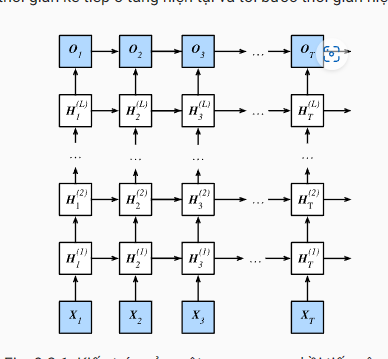

Cho đến nay, chúng ta mới chỉ thảo luận về các mạng nơ-ron hồi tiếp với duy nhất một tầng ẩn đơn hướng. Trong đó, cách các biến tiềm ẩn và các quan sát tương tác với nhau còn khá khá tuỳ ý. Đây không phải là một vấn đề lớn miễn là ta vẫn có đủ độ linh hoạt để mô hình hóa các loại tương tác khác nhau. Tuy nhiên, đây lại là một thách thức với các mạng đơn tầng. Trong trường hợp của perceptron, chúng ta giải quyết vấn đề này bằng cách đưa thêm nhiều tầng vào mạng. Cách này hơi phức tạp một chút với trường hợp của mạng RNN, vì đầu tiên chúng ta cần phải quyết định thêm tính phi tuyến vào mạng ở đâu và như thế nào. Thảo luận dưới đây tập trung chủ yếu vào LSTM, nhưng cũng có thể áp dụng cho các mô hình chuỗi khác.

- Chúng ta có thể bổ sung thêm tính phi tuyến vào các cơ chế cổng. Nghĩa là, thay vì sử dụng một tầng perceptron duy nhất, chúng ta có thể sử dụng nhiều tầng perceptron. Cách này không làm thay đổi cơ chế của mạng LSTM, ngược lại, còn làm cho nó tinh xảo hơn. Điều này chỉ có lợi nếu chúng ta tin rằng cơ chế LSTM biểu diễn một hình thái phổ quát nào đó về cách hoạt động của các mô hình tự hồi quy biến tiềm ẩn.

- Chúng ta có thể chồng nhiều tầng LSTM lên nhau. Cách này tạo ra một cơ chế linh hoạt hơn nhờ vào sự kết hợp giữa các tầng đơn giản. Đặc biệt là, các đặc tính liên quan của dữ liệu có thể được biểu diễn ở các tầng khác nhau. Ví dụ, chúng ta có thể muốn lưu dữ liệu về tình hình thị trường tài chính (thị trường giá lên hay giá xuống) ở tầng cao hơn, trong khi đó chỉ ghi lại động lực thời hạn ngắn hơn ở một tầng thấp hơn.

# Bé tập Code

In [2]:
# Import thư viện
!pip install d2l

import math
import torch
from torch import nn
from torch.nn import functional as F
from d2l import torch as d2l

In [4]:
class RNNScratch(d2l.Module):
    def __init__(self, num_inputs, num_hiddens, sigma=0.01):
        super().__init__()
        self.save_hyperparameters()
        self.W_xh = nn.Parameter(
            torch.randn(num_inputs, num_hiddens) * sigma)
        self.W_hh = nn.Parameter(
            torch.randn(num_hiddens, num_hiddens) * sigma)
        self.b_h = nn.Parameter(torch.zeros(num_hiddens))


In [5]:
class StackedRNNScratch(d2l.Module):
    def __init__(self, num_inputs, num_hiddens, num_layers, sigma=0.01):
        super().__init__()
        self.save_hyperparameters()
        self.rnns = nn.Sequential(*[d2l.RNNScratch(
            num_inputs if i==0 else num_hiddens, num_hiddens, sigma)
                                    for i in range(num_layers)])

In [6]:
@d2l.add_to_class(StackedRNNScratch)
def forward(self, inputs, Hs=None):
    outputs = inputs
    if Hs is None: Hs = [None] * self.num_layers
    for i in range(self.num_layers):
        outputs, Hs[i] = self.rnns[i](outputs, Hs[i])
        outputs = torch.stack(outputs, 0)
    return outputs, Hs

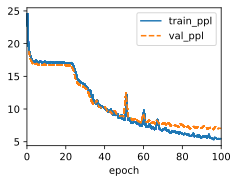

In [7]:
data = d2l.TimeMachine(batch_size=1024, num_steps=32)
rnn_block = StackedRNNScratch(num_inputs=len(data.vocab),
                              num_hiddens=32, num_layers=2)
model = d2l.RNNLMScratch(rnn_block, vocab_size=len(data.vocab), lr=2)
trainer = d2l.Trainer(max_epochs=100, gradient_clip_val=1, num_gpus=1)
trainer.fit(model, data)